## Forecaster Data Management Use Cases

Notebook illustrates how input data into forecast wrapper using the following methods:

1. direct definition of X (pandas df) and y (pandas series)
2. read from .CSV file (simple)
3. read from .CSV file (unpack hourly forecast into additional observations) [Not Working]
4. empty initial data - add observations incrementally (simple)
5. empty initial data - add observations incrementally (combine SCADA & weather, unpack hourly)
7. add values to methods 1/2/3 [Not Working]
8. backup record [Debug]

### Import forecaster libraries from current directory

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

import fcLib
from fcSelector import ForecasterFramework, default_params
from fcWrapper import ForecasterWrapper

### load example training data from external file

In [2]:
# load training data   
data = pd.read_csv('forecaster_example_data.csv', index_col = 0)
data.index = pd.to_datetime(data.index)

# Split the data into X and y
X_columns = [col for col in data.columns if not 'Ppv_forecast' in col]
y_columns = 'Ppv_forecast_1'
# y_columns = [col for col in data.columns if 'Ppv_forecast' in col]

X = data[X_columns]
y = data[y_columns]

# extract 2 series from X and y for predictions
Xtrain = X.iloc[:-48]
Xpredict1 = X.iloc[-48:-24]
Xpredict2 = X.iloc[-24:]

ytrain = y.iloc[:-48]
ypredict1 = y.iloc[-48:-24]
ypredict2 = y.iloc[-24:]

# package data for framework
data_eval = {
    'X': Xtrain,
    'y': ytrain
}

# simple func to plot predictions vs target
def plotPredictions(dataPred, dataAct):
    
    # convert dataPred from list to df with same index as dataAct
    ts = list(dataAct.index)
    zipped = list(zip(ts, dataPred))
    dataPred = pd.DataFrame(zipped, columns=['ts', 'value'])
        
    plt.figure(figsize = (10, 6))
    plt.plot(dataAct.index, dataAct, label = 'target', linestyle = 'dashed')
    plt.plot(dataPred.ts, dataPred.value, label = 'prediction')

    plt.legend()

    plt.tight_layout()
    plt.show()

### generate a list of forecaster candidates from models in fcLib

In [3]:
# create a list of forecaster candidate to evalute
fcList = fcLib.forecaster_list

# selecting 4 arbitrary forecaster options
fcListUser = [fcList[ii] for ii in [2,8,9,11]]

### Example inputs to provide Forecaster Wrapper

In [4]:
exampleInput = {

    'forecaster-list': fcListUser, 
    
     # field for adding new data to dataset
    'data-timestamp': None, # optional input for new record
    'scada-data': None, # str of json fron SCADA
    'weather-data': None, # df of weather forecast
    
    'training-data': {
        # direct data input
        'dataX': Xtrain, 
        'dataY': ytrain,
        
        # options for structuring data
        'columnList': ['a', 'b', 'c'],
        'targetName': 't',
        'unpackHourly': False,
        
        # option for reading file
        'input-path': './testInput.csv',
        
        # option for adding new row to data
        'newRecord': None, # data dict with timestamp as key, nest dict as data,     
    
        # training options
        'trainSize': 0.66,
        'trainMethod': 'train_test_split',
        'minDays': 12,
        
        # retraining interval
        'trainingInterval': 60*60*24,
        
        # backup options
        'backupData': True,
        'backupPath': './testRecord.csv',
        'backupInterval': 60,
    },
    
    'input-data': Xpredict1
}

### Case 1. Pass X and y directly

2023-04-21 14:52:14 INFO     evaluating model randomforestpipeline


running compute
using X and y directly


2023-04-21 14:52:37 INFO     evaluating model randomforest
2023-04-21 14:52:39 INFO     evaluating model extratrees
2023-04-21 14:52:40 INFO     evaluating model stats_sarimax
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14723D+00    |proj g|=  2.98005D-02

At iterate    5    f=  7.13752D+00    |proj g|=  5.07313D-02

At iterate   10    f=  7.13005D+00    |proj g|=  5.96586D-03

At iterate   15    f=  7.12991D+00    |proj g|=  1.24243D-03

At iterate   20    f=  7.12912D+00    |proj g|=  9.52824D-03

At iterate   25    f=  7.12687D+00    |proj g|=  1.94392D-02

At iterate   30    f=  7.12540D+00    |proj g|=  7.75712D-02

At iterate   35    f=  7.05087D+00    |proj g|=  2.48434D-01

At iterate   40    f=  7.02900D+00    |proj g|=  4.72827D-03

At iterate   45    f=  7.02890D+00    |proj g|=  4.04474D-03

At iterate   50    f=  7.02890D+00    |proj g|=  6.61124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

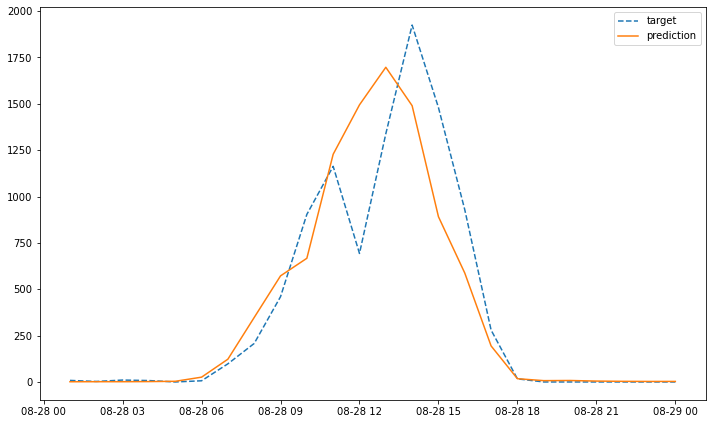

In [5]:
# instantiate forecast framework wrapper
n1 = ForecasterWrapper()

# update input data
newInputs = {
    'forecaster-list': fcListUser, 
    'training-data': {
        
        # direct data input
        'dataX': Xtrain, 
        'dataY': ytrain,
    },
    
    'input-data': Xpredict1
}

n1.input = newInputs

# run compute method to train and predict
n1.compute()

plotPredictions(n1.output['output-data'] , ypredict1)

### Case 2. Read from CSV file (Simple)

running compute


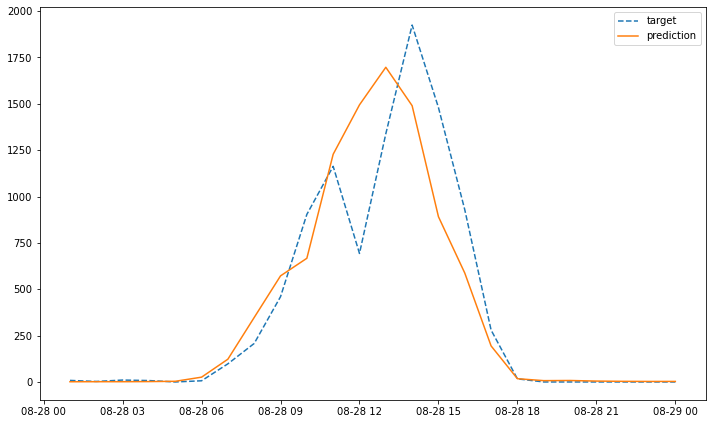

In [6]:
# load training data   
data = pd.read_csv('forecaster_example_data_simple.csv', index_col = 0)
data.index = pd.to_datetime(data.index)

# Split the data into X and y
X_columns = [col for col in data.columns if not 'Ppv_forecast_1' in col]
y_columns = 'Ppv_forecast_1'
# y_columns = [col for col in data.columns if 'Ppv_forecast' in col]

X = data[X_columns]
y = data[y_columns]

# extract 2 series from X and y for predictions
Xtrain = X.iloc[:-48]
Xpredict1 = X.iloc[-48:-24]
Xpredict2 = X.iloc[-24:]

ytrain = y.iloc[:-48]
ypredict1 = y.iloc[-48:-24]
ypredict2 = y.iloc[-24:]

# update input data
newInputs = {
    'forecaster-list': fcListUser, 
    'training-data': {
        # direct data input
        'inputPath': './forecaster_example_data_simple.csv',
        'columnList': list(data.columns),
        'targetName': 'Ppv_forecast_1',
        'unpackHourly': False
    },

    'input-data': Xpredict1
}

n1.input = newInputs

# run compute method to train and predict
n1.compute()

plotPredictions(n1.output['output-data'] , ypredict1)

### Case 3. Read from CSV file (Unpack Hourly) (Not Working)

### Case 4. Initialize empty  data. Add values (Simple)

In [7]:
# define list of generic new records to add to training data set (1 by 1)
newRecords = [
    {
        '2018-07-21 00:00:00': {
            'c1': 11,
            'c2': 22,
            'c3': 1,
            't': 101,
            'ts1': [1,2,3,4,5],
            'ts2': [24,25,26,27,28]
        }
    },
    {
        '2018-07-21 01:00:00': {
            'c1': 13,
            'c2': 25,
            'c3': 2,
            't': 103,
            'ts1': [11,2,3,4,5],
            'ts2': [24,25,26,27,28]
        }
    },
    {
        '2018-07-21 02:00:00': {
            'c1': 15,
            'c2': 35,
            'c3': 4,
            't': 112,
            'ts1': [12,2,3,4,5],
            'ts2': [24,25,26,27,28]
        }
    },
    {
        '2018-07-21 03:00:00': {
            'c1': 16,
            'c2': 44,
            'c3': 5,
            't': 124,
            'ts1': [13,2,3,4,5],
            'ts2': [24,25,26,27,28]
        }
    },
    {
        '2018-07-21 04:00:00': {
            'c1': 17,
            'c2': 49,
            'c3': 6,
            't': 144,
            'ts1': [14,2,3,4,5],
            'ts2': [24,25,26,27,28]
        }
    },
    {
        '2018-07-21 05:00:00': {
            'c1': 17,
            'c2': 49,
            'c3': 6,
            't': 144,
            'ts1': [14,2,3,4,5],
            'ts2': [24,25,26,27,28]
        }
    },
    {
        '2018-07-21 06:00:00': {
            'c1': 17,
            'c2': 49,
            'c3': 6,
            't': 144,
            'ts1': [14,2,45,56,77],
            'ts2': [24,25,26,27,28]
        }
    }
]



# create initial inputs with no training data
# target column name currently required
newInputs = {
    'forecaster-list': fcListUser, 
    'training-data': {
        'targetName': 't',
    }
}

# update inputs and run compute 
# compute method will return error msg saying no training data 
n1.input = newInputs
n1.compute()


# iterate through each new record to add 1 by 1
for recordDataItem in newRecords:

    newInput2 = {
        'forecaster-list': fcListUser, 
        'training-data': {
            'targetName': 't',
            'newRecord': recordDataItem 
            
        }
    }

    n1.input = newInput2

    # run compute to integrate new record into training data
    # insufficient total data, so forecaster evaluation will not yet run
    # curently generates warning/error messages
    n1.compute()

print('Stored Training Data X:')
print(n1.trainingData['X'])

print('\nStored Training Data y:')
print(n1.trainingData['y'])

running compute
running compute
running compute
running compute
running compute
running compute
running compute
running compute
Stored Training Data X:
                     Tamb_forecast_1  Tamb_forecast_2  Tamb_forecast_3  \
2018-07-20 23:00:00             16.1             15.6             15.6   
2018-07-21 00:00:00             15.6             15.6             15.6   
2018-07-21 01:00:00             15.6             15.6             15.0   
2018-07-21 02:00:00             15.6             15.0             14.4   
2018-07-21 03:00:00             15.0             14.4             14.4   
...                              ...              ...              ...   
2018-08-27 20:00:00             13.9             13.3             12.8   
2018-08-27 21:00:00             13.3             12.8             12.8   
2018-08-27 22:00:00             12.8             12.8             12.8   
2018-08-27 23:00:00             12.8             12.8             12.8   
2018-08-28 00:00:00             12

### Case 5. Initialize empty  data. Add values (Combine SCADA & Weather sources)

In [8]:
# function for generating example scada observation
def example_scada():
    data = {'soc': 0.5, 'pmax': 1e3, 'emax': 5e3, 
            'echa': 0.96, 'edis': 0.96, 'smin': 0.1, 'smax': 1.0}
    scada1 = pd.DataFrame(index=range(len(data)*3), columns=['name', 'value', 'valid', 'error'])
    ix = 0
    for par, v in data.items():
        for i in range(3):
            scada1.loc[ix, :] = [f'irn{i}_battery-{par}', v, 1, '']
            ix += 1
    return scada1.to_json()

def example_scada_random():
    # generates a list of SCADA readings with randome SOCs           
    data = {'soc': 99, 'pmax': 1e3, 'emax': 5e3, 
            'echa': 0.96, 'edis': 0.96, 'smin': 0.1, 'smax': 1.0}
    
    scada1 = pd.DataFrame(index=range(len(data)*3), columns=['name', 'value', 'valid', 'error'])
    ix = 0
    for par, v in data.items():
        for i in range(3):
            
            # overwrite static SOC with random value
            if par == 'soc':
                v = round(random.uniform(0.25, 0.9), 2)
            
            scada1.loc[ix, :] = [f'irn{i}_battery-{par}', v, 1, '']
            ix += 1
    return scada1.to_json()

def example_weather_forecast_random():
    
    weatherFilePath = os.path.abspath(os.path.join(os.getcwd(), 
                'example_weatherforecast.csv'))

    newWeatherRecord = pd.read_csv(weatherFilePath, index_col=0)
    
    # generate random value to scale forecast by
    scaleVal = random.uniform(0.95, 1.05)
    
    newWeatherRecord[newWeatherRecord.select_dtypes(include=['number']).columns] *= scaleVal

    return newWeatherRecord

newScadaRecord = example_scada()

# read example weather forecast from external file
# includes multiple hours of forecasted data to be unstacked for each observation timestamp
weatherFilePath = os.path.abspath(os.path.join(os.getcwd(), 
                'example_weatherforecast.csv'))

newWeatherRecord = pd.read_csv(weatherFilePath, index_col=0)



# create initial inputs with no training data
# target column name currently required
newInputs = {
    'forecaster-list': fcListUser, 
    'training-data': {
        'targetName': 'irn0_battery-edis',
        'unpackHourly': True
    }
}

# update inputs and run compute 
# compute method will return error msg saying no training data 
n1.input = newInputs
n1.compute()


# iterate through each new record to add 1 by 1
for rr in range(0,10):

    # create generic hypothetical timestamp
    dataTs=f'2018-07-21 {rr:02}:00:00'

    newInput2 = {
        'forecaster-list': fcListUser, 
        
        'data-timestamp':  dataTs,
        'scada-data': example_scada_random(),
        'weather-data': example_weather_forecast_random(),
        
        'training-data': {
            'targetName': 'irn0_battery-edis',
            'unpackHourly': True
        }
    }

    n1.input = newInput2

    # run compute method to train and predict
    n1.compute()
    
print('Stored Training Data X:')
print(n1.trainingData['X'])

print('\nStored Training Data y:')
print(n1.trainingData['y'])

running compute
running compute
running compute
running compute
running compute
running compute
running compute
running compute
running compute
running compute
running compute
Stored Training Data X:
                     Tamb_forecast_1  Tamb_forecast_2  Tamb_forecast_3  \
2018-07-20 23:00:00             16.1             15.6             15.6   
2018-07-21 00:00:00             15.6             15.6             15.6   
2018-07-21 01:00:00             15.6             15.6             15.0   
2018-07-21 02:00:00             15.6             15.0             14.4   
2018-07-21 03:00:00             15.0             14.4             14.4   
...                              ...              ...              ...   
2018-08-27 20:00:00             13.9             13.3             12.8   
2018-08-27 21:00:00             13.3             12.8             12.8   
2018-08-27 22:00:00             12.8             12.8             12.8   
2018-08-27 23:00:00             12.8             12.8       

### Case 6. Add observations to Cases 1, 2, and 3

### Case 7. Backup training data to file

To backup training data to an external csv file, the following items must be passed in 'training-data' dict:

1. backupData - (bool) option to enable external backup. Default True
2. backupPath - (str) path and filename to external backup locations
3. backupInterval - (int) duration in seconds until a new backup should be written

New backup parameters can be passed in 'training-data' at anytime and will overwrite previous parameters.

**NOTE**: back-up functionality incomplete for direct X&y data method. Should work for all other data-input methods.

In [9]:
# define path for external backup
backupPath = './TEST_backup.csv'

# delete previous backup (if it exists)
if os.path.exists(backupPath):
    os.remove(backupPath)
    
# instantiate forecast framework wrapper
n1 = ForecasterWrapper()

# update input data
newInputs = {
    'forecaster-list': fcListUser, 
    'training-data': {
        # direct data input
        'inputPath': './forecaster_example_data_simple.csv',
        'columnList': list(data.columns),
        'targetName': 'Ppv_forecast_1',
        'unpackHourly': False,
        'backupData': True,
        'backupPath': backupPath,
        'backupInterval': 5
    }
}

n1.input = newInputs

# run compute to initialize data classes
n1.compute()

# wait 5+ sec to ensure backupInterval has been met
time.sleep(10)

# run compute method again to trigger backup
print('re-running compute')
n1.compute()

# confirm that backup file exists
print(f'backup file {backupPath} exists: {os.path.exists(backupPath)}')

if os.path.exists(backupPath):
    backupDf = pd.read_csv(backupPath, index_col = 0)
    print(backupDf.head())

2023-04-21 14:52:42 INFO     running backup check in wrapper
2023-04-21 14:52:42 INFO     checking backup interval


running compute


2023-04-21 14:52:42 INFO     backup interval not met 0:00:00.072364 - 5. No backup executed
2023-04-21 14:52:42 INFO     evaluating model randomforestpipeline
2023-04-21 14:52:42 INFO     evaluating model randomforest
2023-04-21 14:52:42 INFO     evaluating model extratrees
2023-04-21 14:52:42 INFO     evaluating model stats_sarimax
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07526D+00    |proj g|=  6.32682D-02

At iterate    5    f=  7.04376D+00    |proj g|=  7.55041D-03

At iterate   10    f=  7.04003D+00    |proj g|=  1.29357D-03

At iterate   15    f=  7.03974D+00    |proj g|=  1.63184D-02

At iterate   20    f=  7.03927D+00    |proj g|=  5.05499D-03

At iterate   25    f=  7.03539D+00    |proj g|=  5.93894D-02

At iterate   30    f=  6.97272D+00    |proj g|=  5.65410D-03

At iterate   35    f=  6.97233D+00    |proj g|=  4.75607D-04

At iterate   40    f=  6.97231D+00    |proj g|=  5.06483D-03

At iterate   45    f=  6.97115D+00    |proj g|=  3.75760D-02

At iterate   50    f=  6.97082D+00    |proj g|=  2.99680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

2023-04-21 14:52:54 INFO     running backup check in wrapper
2023-04-21 14:52:54 INFO     checking backup interval
2023-04-21 14:52:54 INFO     Saving training data to file


re-running compute
running compute
backup file ./TEST_backup.csv exists: True
                     Tamb_forecast_1  clear_sky_forecast_1  \
2018-07-20 23:00:00             16.1                   0.0   
2018-07-21 00:00:00             15.6                   0.0   
2018-07-21 01:00:00             15.6                   0.0   
2018-07-21 02:00:00             15.6                   0.0   
2018-07-21 03:00:00             15.0                   0.0   

                     cloud_cover_forecast_1  Ppv_dminus1_forecast_1  \
2018-07-20 23:00:00                      55                     0.0   
2018-07-21 00:00:00                      55                     0.0   
2018-07-21 01:00:00                      55                     0.0   
2018-07-21 02:00:00                      55                     0.0   
2018-07-21 03:00:00                      55                     0.0   

                     Ppv_forecast_1  
2018-07-20 23:00:00        0.000000  
2018-07-21 00:00:00        0.000000  
2018-07-

In [10]:
n1.dataManager.backupInterval

5

In [11]:
backupDf.head()

,Tamb_forecast_1,clear_sky_forecast_1,cloud_cover_forecast_1,Ppv_dminus1_forecast_1,Ppv_forecast_1
2018-07-20 23:00:00,16.1,0.0,55,0.0,0.000000
2018-07-21 00:00:00,15.6,0.0,55,0.0,0.000000
2018-07-21 01:00:00,15.6,0.0,55,0.0,1.304373
2018-07-21 02:00:00,15.6,0.0,55,0.0,4.703539
2018-07-21 03:00:00,15.0,0.0,55,0.0,11.268172


In [12]:
x = example_weather_forecast_random()

In [13]:
x.index[0]

'2022-11-29 12:00:00'